<img src='https://upload.wikimedia.org/wikipedia/fr/thumb/e/ed/Logo_Universit%C3%A9_du_Maine.svg/1280px-Logo_Universit%C3%A9_du_Maine.svg.png' width="300" height="500">
<br>
<div style="border: solid 3px #000;">
    <h1 style="text-align: center; color:#000; font-family:Georgia; font-size:26px;">Infrastructures pour l'IA</h1>
    <p style='text-align: center;'>Master Informatique 1</p>
    <p style='text-align: center;'>Anhony Larcher</p>
</div>

Dans cet exercice nous allons classifier les image sde la base de données MNIST un réseau de neurones profonds

## Importez un package qui vous permette de tracer ces graphiques

In [3]:
import matplotlib.pyplot as plt
# ou 
#import seaborn as sns

## Importez PyTorch et téléchargez MNIST

In [4]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import OrderedDict
from torchvision import datasets, transforms


transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])




# Get the test dataset
#test_set = datasets.MNIST(root = './',
#                          download = True, train = False, transform = transform)


/Users/alarcher/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Préparez les données d'apprentissage et de développement

In [5]:
batch_size = 16

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))])

train_set = torchvision.datasets.MNIST('./files/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
                                       
                                       
validation_set = torchvision.datasets.MNIST('./files/', train=False, download=True, transform=transform)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)

# Regardez quelques données

In [6]:
examples = enumerate(validation_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

torch.Size([16, 1, 28, 28])

## Visualisez quelques exemples de MNIST
Chaque ligne de X est un vecteur qui contient les 784 valeurs des pixels d'une image 28x28 en niveaux de gris

Affichez les 4 premiers exemples de cette base de données avec leur label

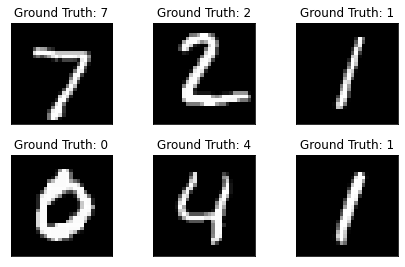

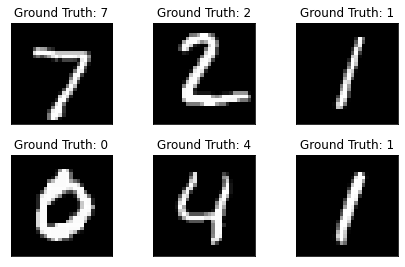

In [7]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

# Créez un réseau de neurones

In [8]:
class Net(nn.Module):
    def __init__(self, nb_layers=2, hidden_size=128, activation="LeakyReLU", device='cpu', bias=True):
        super(Net, self).__init__()
    
        if activation == "LeakyReLU":
            activation_function = torch.nn.LeakyReLU()
        elif activation == "glu":
            activation_function = torch.nn.GLU()
        elif activation == "ReLu":
            activation_function = torch.nn.ReLu()
        else:
            print("Activation function not implemented")

        self.input_layer = nn.Linear(in_features=784, 
                                     out_features=hidden_size, 
                                     bias=bias, 
                                     device=device)
        
        layers = [
            ("input_layer", self.input_layer), 
            ("input_activation", activation_function)
        ]
        
        for ii in range(nb_layers):
            layers.append(
                (f"layer_{ii}", nn.Linear(in_features=hidden_size,
                                          out_features=hidden_size,
                                          bias=bias,
                                          device=device))
                )
            layers.append((f"activation_{ii}", activation_function))
 
        self.model = torch.nn.Sequential(OrderedDict(layers))
            
        self.classif_layer = nn.Linear(in_features=hidden_size,
                                       out_features=10,
                                       bias=bias,
                                       device=device)

    # x represents our data
    def forward(self, x):

        x = self.model(x)
        x = self.classif_layer(x)
        
        return x.squeeze()
    
network = Net(nb_layers=5, hidden_size=32, activation="glu", device='cpu', bias=True)


In [9]:
print(network)

Net(
  (input_layer): Linear(in_features=784, out_features=32, bias=True)
  (model): Sequential(
    (input_layer): Linear(in_features=784, out_features=32, bias=True)
    (input_activation): GLU(dim=-1)
    (layer_0): Linear(in_features=32, out_features=32, bias=True)
    (activation_0): GLU(dim=-1)
    (layer_1): Linear(in_features=32, out_features=32, bias=True)
    (activation_1): GLU(dim=-1)
    (layer_2): Linear(in_features=32, out_features=32, bias=True)
    (activation_2): GLU(dim=-1)
    (layer_3): Linear(in_features=32, out_features=32, bias=True)
    (activation_3): GLU(dim=-1)
    (layer_4): Linear(in_features=32, out_features=32, bias=True)
    (activation_4): GLU(dim=-1)
  )
  (classif_layer): Linear(in_features=32, out_features=10, bias=True)
)


# Testez votre réseau en passant des données dedans

In [17]:
# Equates to one random 28x28 image
example_data = example_data.reshape(example_data.shape[0], example_data.shape[1], example_data.shape[2] * example_data.shape[3])
network = Net()
result = network(example_data)
print (result)

tensor(2.3003, grad_fn=<NllLossBackward0>)


# Créez un optimizer

In [31]:
lr = 1e-3
momentum = 0.5
log_interval = 100
n_epochs = 10
optimizer = optim.SGD(network.parameters(), lr=lr, momentum=momentum)

# Entrainez votre réseau

In [32]:
train_losses = []
train_counter = []
validation_losses = []
validation_counter = [i*len(validation_loader.dataset) for i in range(n_epochs + 1)]

In [33]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.reshape(data.shape[0], data.shape[1], data.shape[2] * data.shape[3])
    optimizer.zero_grad()
    output = network(data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [36]:
def validation():
    network.eval()
    validation_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in validation_loader:
            data = data.reshape(data.shape[0], data.shape[1], data.shape[2] * data.shape[3])
            output = network(data)
            validation_loss += F.cross_entropy(output, target)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    validation_loss /= len(validation_loader.dataset)
    validation_losses.append(validation_loss)
    print('\nValidation set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(validation_loader.dataset),
        100. * correct / len(validation_loader.dataset)))

# Boucle d'apprentissage

On teste une première fois le modèle avec des paramètres aléatoires avant l'apprentissage

In [39]:
validation()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  validation()


Validation set: Avg. loss: 0.0126, Accuracy: 9407/10000 (94%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.037224
Train Epoch: 1 [1600/60000 (3%)]	Loss: 0.084985
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.227972
Train Epoch: 1 [4800/60000 (8%)]	Loss: 0.059857
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.025481
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.048331
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.592596
Train Epoch: 1 [11200/60000 (19%)]	Loss: 0.222040
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.847871
Train Epoch: 1 [14400/60000 (24%)]	Loss: 0.064574
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.203825
Train Epoch: 1 [17600/60000 (29%)]	Loss: 0.197780
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.066667
Train Epoch: 1 [20800/60000 (35%)]	Loss: 0.152408
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.111184
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.236799
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.122415
Train Epoch: 1 [27200/60000 (45%)]	Loss: 0.288638
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.379523


KeyboardInterrupt: 

# Tracez les performances d'apprentissage

ValueError: x and y must be the same size

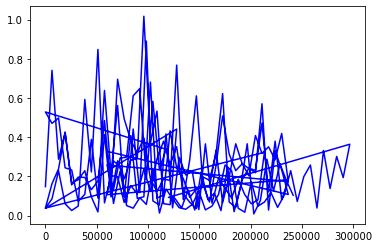

In [40]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(validation_counter, validation_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

# Passez sur GPU

Modifiez maintenant le code pour l'exécuter sur GPU et comparez la vitesse d'apprentissage